## This notebook explores fuel types and the volumes of cargo transfered by fuel type

This notebook requires an activation of the `monte_carlo` environment setup 
located in `analysis-rachael/env`
```
conda activate monte_carlo
```

The newest versions of the monte-carlo spills files can be found on Salish at the following location:
`/ocean/rmueller/MIDOSS/spill_files_TLPcorrected`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from monte_carlo_utils import decimal_divide
from pathlib import Path

In [2]:
# unit conversions
gal2m3 = 0.00378541

In [3]:
# User inputs
file_dir  = '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'
# location of output fro excel spreadsheets
output_directory = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')

# This is the precision used to calculate oil type weights 
# Trial and error showed that a precision of 2 is neccessary for weights
# to sum to 1.0
precision = 2

# Import columns are: (G) Deliverer, (H) Receiver, (O) Region, (P) Product, 
#                     (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)', 
#                     (w) DelivererTypeDescription, (x) ReceiverTypeDescription 
DOE_df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
               usecols="G,H,P,Q,R,W,X")
[nrows,ncols] = DOE_df.shape

In [4]:
# The following list includes facilities used in Casey's origin/destination analysis 
# with names matching the Dept. of Ecology (DOE) database.  
# For example, the shapefile "Maxum Petroleum - Harbor Island Terminal" is labeled as 'Maxum (Rainer Petroleum)'
# in the DOE database.  I use the Ecology language here and will need to translate to Shapefile speak

# Terminals that are grouped in voyage joins are removed, e.g.:
# 'Maxum (Rainer Petroleum)' and 'Shell Oil LP Seattle Distribution Terminal' are represented in
#  ==>'Kinder Morgan Liquids Terminal - Harbor Island' 
facility_names = [ 'BP Cherry Point Refinery', 'Shell Puget Sound Refinery', 
                   'Tidewater Snake River Terminal','Nustar Energy Tacoma', 
                   'SeaPort Sound Terminal', 'Tesoro Vancouver Terminal', 'Phillips 66 Ferndale Refinery', 
                   'Phillips 66 Tacoma Terminal', 'Andeavor Anacortes Refinery (formerly Tesoro)',
                   'Tesoro Port Angeles Terminal','U.S. Oil & Refining','Naval Air Station Whidbey Island (NASWI)',
                   'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 
                   'Kinder Morgan Liquids Terminal - Harbor Island' ,  
                   'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 'Tidewater Vancouver Terminal',
                   'TLP Management Services LLC (TMS)']

# list of facility names to query monte-carlo csv file
# Marathon Anacortes Refinery (formerly Tesoro) instead of Andeavor Anacortes Refinery (formerly Tesoro)
# Maxum Petroleum - Harbor Island Terminal instead of Maxum (Rainer Petroleum)
facility_names_mc = [ 'BP Cherry Point Refinery', 'Shell Puget Sound Refinery',
                   'Tidewater Snake River Terminal', 
                   'SeaPort Sound Terminal', 'Tesoro Vancouver Terminal','Phillips 66 Ferndale Refinery', 
                   'Phillips 66 Tacoma Terminal', 'Marathon Anacortes Refinery (formerly Tesoro)',
                   'Tesoro Port Angeles Terminal','U.S. Oil & Refining','Naval Air Station Whidbey Island (NASWI)',
                   'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 'Kinder Morgan Liquids Terminal - Harbor Island',
                   'Nustar Energy Tacoma', 'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 'Tidewater Vancouver Terminal',
                   'TLP Management Services LLC (TMS)']

### Catalogue the DOE data to match the way that we grouped marine terminals in our origin-destination analysis, due to proximity, e.g. (using abbr names in some cases):
- Maxum + Shell Oil LP + Kinder Morgan -> 'Kinder Morgan Liquids Terminal - Harbor Island'
- Nustar Tacoma
- Nustar Vancouver (?)
- Tesoro Pasco
- Tidewater Snake
- Tidewater Vancouver

In [5]:
# First, count the terminals that we are still missing in groupings
print('Nustar Tacoma: ', DOE_df.loc[
    ((DOE_df.Deliverer == 'Nustar Energy Tacoma') |
    (DOE_df.Receiver == 'Nustar Energy Tacoma')),
].Deliverer.count())
print('Tesoro Pasco Terminal', DOE_df.loc[
    ((DOE_df.Deliverer == 'Tesoro Pasco Terminal') |
    (DOE_df.Receiver == 'Tesoro Pasco Terminal')),
].Deliverer.count())
print('Tidewater Snake River Terminal', DOE_df.loc[
    ((DOE_df.Deliverer == 'Tidewater Snake River Terminal') |
    (DOE_df.Receiver == 'Tidewater Snake River Terminal')),
].Deliverer.count())
print('Tidewater Vancouver Terminal', DOE_df.loc[
    ((DOE_df.Deliverer == 'Tidewater Vancouver Terminal') |
    (DOE_df.Receiver == 'Tidewater Vancouver Terminal')),
].Deliverer.count())

Nustar Tacoma:  3
Tesoro Pasco Terminal 112
Tidewater Snake River Terminal 445
Tidewater Vancouver Terminal 64


In [6]:
# count transfers prior to re-name
MaxumDOE = DOE_df.loc[
    ((DOE_df.Deliverer == 'Maxum (Rainer Petroleum)') |
    (DOE_df.Receiver == 'Maxum (Rainer Petroleum)')),
].Deliverer.count()
ShellDOE = DOE_df.loc[
    ((DOE_df.Deliverer == 'Shell Oil LP Seattle Distribution Terminal') |
    (DOE_df.Receiver == 'Shell Oil LP Seattle Distribution Terminal')),
].Deliverer.count()
KinderDOE = DOE_df.loc[
    ((DOE_df.Deliverer == 'Kinder Morgan Liquids Terminal - Harbor Island') |
    (DOE_df.Receiver == 'Kinder Morgan Liquids Terminal - Harbor Island')),
].Deliverer.count()

# housekeeping: Force one name per marine transfer site for cases of data entry mistakes
DOE_df = DOE_df.replace(
    to_replace="TLP",
    value = "TLP Management Services LLC (TMS)"
)
DOE_df = DOE_df.replace(
    to_replace = "US Oil Tacoma ",
    value = "U.S. Oil & Refining"
)

In [7]:
# rename 'Maxum (Rainer Petroleum)' and 'Shell Oil LP Seattle Distribution Terminal' as 'Kinder Morgan Liquids Terminal - Harbor Island'
DOE_df['Deliverer'] = DOE_df['Deliverer'].replace(
    ['Maxum (Rainer Petroleum)','Shell Oil LP Seattle Distribution Terminal'], 
    'Kinder Morgan Liquids Terminal - Harbor Island'
)
DOE_df['Receiver'] = DOE_df['Receiver'].replace(
    ['Maxum (Rainer Petroleum)','Shell Oil LP Seattle Distribution Terminal'],
    'Kinder Morgan Liquids Terminal - Harbor Island'
)
    
# recount transfers
MaxumShellKinderDOE = DOE_df.loc[
    ((DOE_df.Deliverer == 'Kinder Morgan Liquids Terminal - Harbor Island') |
    (DOE_df.Receiver == 'Kinder Morgan Liquids Terminal - Harbor Island')),
].Deliverer.count()

In [8]:
# verify renaming
print('{MaxumShellKinderDOE} = {MaxumDOE} + {ShellDOE} + {KinderDOE} = {MaxumDOE + ShellDOE + KinderDOE}')
print(f'{MaxumShellKinderDOE} = {MaxumDOE} + {ShellDOE} + {KinderDOE} = {MaxumDOE + ShellDOE + KinderDOE}')

{MaxumShellKinderDOE} = {MaxumDOE} + {ShellDOE} + {KinderDOE} = {MaxumDOE + ShellDOE + KinderDOE}
3021 = 2761 + 3 + 257 = 3021


### Take-away: What we are representing as Kinder Morgan Liquids Terminal is really Maxum transfers (and ought to be named as such)
(And my renaming checks out, accounting wise, as 3021 = 3021)

In [9]:
# identify all names of oils in DOE database that are attributed to our oil types
oil_types    = ['akns', 'bunker', 'dilbit', 'jet', 'diesel', 'gas', 'other']
oil_classification = {}
for oil in oil_types:
    oil_classification[oil] = []

[nrows,ncols] = DOE_df.shape
for row in range(nrows):
    if 'CRUDE' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['akns']:
        oil_classification['akns'].append(DOE_df.Product[row])
    elif 'BAKKEN' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['akns']:
        oil_classification['akns'].append(DOE_df.Product[row])
    elif 'BUNKER' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['bunker']:
        oil_classification['bunker'].append(DOE_df.Product[row])
    elif 'BITUMEN' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['dilbit']:
        oil_classification['dilbit'].append(DOE_df.Product[row])
    elif 'DIESEL' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['diesel']:
        oil_classification['diesel'].append(DOE_df.Product[row])
    elif 'GASOLINE' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['gas']:
        oil_classification['gas'].append(DOE_df.Product[row])
    elif 'JET' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['jet']:
        oil_classification['jet'].append(DOE_df.Product[row])
    elif ('CRUDE' not in DOE_df.Product[row] and
          'BAKKEN' not in DOE_df.Product[row] and
          'BUNKER' not in DOE_df.Product[row] and
          'BITUMEN' not in DOE_df.Product[row] and
          'DIESEL' not in DOE_df.Product[row] and
          'GASOLINE' not in DOE_df.Product[row] and
          'JET' not in DOE_df.Product[row] and
          DOE_df.Product[row] not in oil_classification['other']):
        oil_classification['other'].append(DOE_df.Product[row])

oil_classification

{'akns': ['CRUDE OIL', 'BAKKEN'],
 'bunker': ['BUNKER OIL/HFO'],
 'dilbit': ['BITUMEN OIL (DIL OR SYN)'],
 'jet': ['JET FUEL/KEROSENE'],
 'diesel': ['DIESEL/MARINE GAS OIL', 'BIODIESEL', 'DIESEL LOW SULPHUR (ULSD)'],
 'gas': ['GASOLINE'],
 'other': ['ETHANOL',
  'LUBE OIL/MOTOR OIL',
  'Cat Feed/VGO',
  'CUTTER STOCK',
  'OILY WATER MIXTURE',
  'WASTE OIL',
  'Z-OTHER',
  'HYDRAULIC OIL',
  'OILY WASTE',
  'USED OIL',
  'NAPTHA',
  'EDIBLE/VEGETABLE OIL',
  'DECANT OIL',
  'NONENE',
  'ASPHALT/CREOSEOTE']}

## Initialize lists and dictionaries 

In [10]:
other_import = []
other_export = []
dilbit_receiver = []
dilbit_deliverer = []

# tally transfers and crude imports/exports by facility
transfers_byloc = {}
volume_byloc={}
for facility in facility_names:
    transfers_byloc[facility] = 0
    volume_byloc[facility] = 0

## Add volume transfers and define fuel types

NOTE: I tried using `DOE_df.groupby().TransferQtyInGallon.sum()` and `DOE_df.groupby('Deliverer').count()` together with, e.g. `(DOE_df.Receiver.str.contains('|'.join(facility_names)))` to use dataframe functions to add quantity and count transfers by terminal but found my terminal count fell short using this method for reasons I couldn't debug in a timely manner, so I'm opting for the for-loop/+= method. 


In [11]:
#  This can be simplified with dataframe functions, but I ran out of time to update.
for row in range(nrows):
    
    # ~~~~~~~ COMBINED IMPORTS AND EXPORTS ~~~~~~~
    if (DOE_df.Receiver[row] in facility_names or
        DOE_df.Deliverer[row] in facility_names and 
        DOE_df.TransferType[row] == 'Cargo'
       ):
           
        # ~~~~~~ Tally transfers by terminal ~~~~~~~~~~~  
        if (DOE_df.Receiver[row] in facility_names):
            transfers_byloc[DOE_df.Receiver[row]] += 1
            volume_byloc[DOE_df.Receiver[row]] += DOE_df.TransferQtyInGallon[row]
        elif (DOE_df.Deliverer[row] in facility_names):
            transfers_byloc[DOE_df.Deliverer[row]] += 1
            volume_byloc[DOE_df.Deliverer[row]] += DOE_df.TransferQtyInGallon[row]

In [12]:
transfers = {}
volume = {}
# ~~~ Total import and  export for all oil types ~~~
transfers['total'] = DOE_df.loc[
    (DOE_df.TransferType == 'Cargo') &
    ((DOE_df.Receiver.isin(facility_names)) |
     (DOE_df.Deliverer.isin(facility_names))), 
].shape[0]

volume['total'] = DOE_df.loc[
    (DOE_df.TransferType == 'Cargo') &
    ((DOE_df.Receiver.isin(facility_names)) |
     (DOE_df.Deliverer.isin(facility_names))),
    'TransferQtyInGallon'
].sum(axis=0).item()

# ~~~ Total import and  export by oil types ~~~
for oil in oil_types:
    transfers[oil] = DOE_df.loc[
        (DOE_df.TransferType == 'Cargo') &
        (DOE_df.Product.isin(oil_classification[oil])) &
        ((DOE_df.Receiver.isin(facility_names)) |
         (DOE_df.Deliverer.isin(facility_names))), 
    ].shape[0]

    volume[oil] = DOE_df.loc[
        (DOE_df.TransferType == 'Cargo') &
        (DOE_df.Product.isin(oil_classification[oil])) &
        ((DOE_df.Receiver.isin(facility_names)) |
         (DOE_df.Deliverer.isin(facility_names))),
        'TransferQtyInGallon'
    ].sum(axis=0).item()

### Tally volume transferred for 'other' fuel types¶

In [13]:
# for some reason, the above list is incomplete.  It's missing hydraulic oil
other = {}
other['types'] = []
# make complete list of "other" oil types
for row in range(nrows):   
    # ~~~~~~~ COMBINED IMPORTS AND EXPORTS ~~~~~~~
    if (DOE_df.Receiver[row] in facility_names or
        DOE_df.Deliverer[row] in facility_names and 
        DOE_df.TransferType[row] == 'Cargo'
       ):
        # "Other" fuel-type exports 
        if ('CRUDE' not in DOE_df.Product[row] and 
            'BUNKER OIL/HFO' not in DOE_df.Product[row] and 
            'GASOLINE' not in DOE_df.Product[row] and
            'JET FUEL/KEROSENE' not in DOE_df.Product[row] and
            'DIESEL' not in DOE_df.Product[row] 
           ):
            if DOE_df.Product[row] not in other['types']:
                other['types'].append(DOE_df.Product[row])
               
other['types']

['Cat Feed/VGO',
 'ETHANOL',
 'CUTTER STOCK',
 'OILY WASTE',
 'WASTE OIL',
 'NAPTHA',
 'Z-OTHER',
 'EDIBLE/VEGETABLE OIL',
 'DECANT OIL',
 'NONENE',
 'LUBE OIL/MOTOR OIL',
 'BITUMEN OIL (DIL OR SYN)',
 'HYDRAULIC OIL',
 'USED OIL',
 'BAKKEN',
 'ASPHALT/CREOSEOTE']

In [14]:
other['volume_gallons'] = np.zeros(len(other['types']))
other['transfers'] = np.zeros(len(other['types']))

# Now use name of "other" product to find index for tallying volumes and transfers
for row in range(nrows):   
    # ~~~~~~~ COMBINED IMPORTS AND EXPORTS ~~~~~~~
    if (DOE_df.Receiver[row] in facility_names or
        DOE_df.Deliverer[row] in facility_names and 
        DOE_df.TransferType[row] == 'Cargo'
       ):
        # "Other" fuel-type exports 
        if ('CRUDE' not in DOE_df.Product[row] and 
            'BUNKER OIL/HFO' not in DOE_df.Product[row] and 
            'GASOLINE' not in DOE_df.Product[row] and
            'JET FUEL/KEROSENE' not in DOE_df.Product[row] and
            'DIESEL' not in DOE_df.Product[row] 
           ):
            oil_index = other['types'].index(DOE_df.Product[row])
            other['volume_gallons'][oil_index] += DOE_df.TransferQtyInGallon[row]
            other['transfers'][oil_index] += 1
            
other['volume_m3'] = [gal2m3 * volume for volume in other['volume_gallons']]

### Create dataframe for viewing and exporting

#### by oil types

In [15]:
# create dataframe from dictionary
oil_type_transfers = pd.DataFrame(data=transfers,index=[1])
oil_type_volume = pd.DataFrame(data=volume,index=[0])
# dataframe with oil types as columns
oil_type_cols = oil_type_transfers.append(oil_type_volume)
oil_type_cols.index = ['transfers','volume_gallons']

# dataframe with oil types as rows
oil_type = oil_type_cols.transpose().sort_values(by=['volume_gallons'], ascending=False).copy()

# convert from gallons to m3 (and keep both for reference)
oil_type['volume_m3'] = [ (gal2m3 * volume) for volume in oil_type['volume_gallons']]
net_volume = oil_type['volume_m3'][0]

# Add volume/transfers to dataframe
m3_per_transfer = [volume/transfers for volume,transfers in zip(oil_type['volume_m3'],oil_type['transfers'])]
oil_type['m3_per_transfer'] = m3_per_transfer

oil_type['percent_total'] = [volume/oil_type['volume_m3'][0] for volume in oil_type['volume_m3']]
oil_type.to_excel(output_directory/"oiltype_transfers.xlsx", sheet_name='oil_types')
oil_type

,transfers,volume_gallons,volume_m3,m3_per_transfer,percent_total
total,4438,9991995621,3.782380e+07,8522.712966,1.000000
akns,312,4080428048,1.544609e+07,49506.708773,0.408370
gas,806,1853729138,7.017125e+06,8706.110194,0.185521
diesel,1198,1330554384,5.036694e+06,4204.251979,0.133162
bunker,1268,1259943411,4.769402e+06,3761.358350,0.126095
other,473,840539504,3.181787e+06,6726.821657,0.084121
jet,375,623699524,2.360958e+06,6295.889107,0.062420
dilbit,6,3101612,1.174087e+04,1956.812180,0.000310


In [16]:
volume

{'total': 9991995621,
 'akns': 4080428048,
 'bunker': 1259943411,
 'dilbit': 3101612,
 'jet': 623699524,
 'diesel': 1330554384,
 'gas': 1853729138,
 'other': 840539504}

/Users/rmueller/opt/miniconda3/envs/monte_carlo/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


1.0

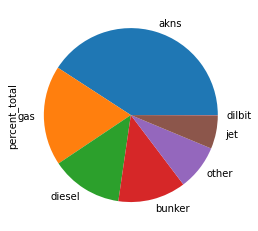

In [17]:
plot_oil_type = oil_type.drop('total')
plot_oil_type['percent_total'].plot.pie()
plot_oil_type['percent_total'].sum()

##### show volumes for "other" oil types

#### by facility

In [18]:
# create dataframe from dictionary
facility_transfers = pd.DataFrame(data=transfers_byloc,index=[0])
facility_volumes = pd.DataFrame(data=volume_byloc,index=[1])
# dataframe with facilities as columns
facility_cols = facility_transfers.append(facility_volumes)
facility_cols.index = ['transfers','volume_gallons']
# dataframe with facilities as rows
facility = facility_cols.transpose().sort_values(by=['volume_gallons'], ascending=False).copy()
facility

,transfers,volume_gallons
BP Cherry Point Refinery,543,3562469570
Shell Puget Sound Refinery,408,1997329772
Andeavor Anacortes Refinery (formerly Tesoro),425,1281986324
Phillips 66 Ferndale Refinery,638,1251999000
SeaPort Sound Terminal,410,381362598
U.S. Oil & Refining,260,291951121
Alon Asphalt Company (Paramount Petroleum),451,288611987
Tidewater Snake River Terminal,244,243723742
Kinder Morgan Liquids Terminal - Harbor Island,369,211122332
Tesoro Pasco Terminal,112,107662726


In [19]:
# Add column for volume in m3 
facility['volume_m3'] = [(gal2m3 * volume) for volume in facility['volume_gallons']]


# Add volume/transfers to dataframe
facility['m3_per_transfer'] = [volume/transfer for volume,transfer in zip(facility['volume_m3'],facility['transfers'])]
facility['percent_total_volume'] = [100*volume/net_volume for volume in facility['volume_m3']]

# format output
format_mapping={'transfers':'{:,.0f}', 'volume_gallons':'{:.2E}', 'volume_m3':'{:.2E}', 'm3_per_transfer':'{:.2E}', 'percent_total_volume':'{:.2f}%'}
for key, value in format_mapping.items():
    facility[key] = facility[key].apply(value.format)
facility.index.name='LOCATION'
facility.to_excel(output_directory/"facility_transfers.xlsx", sheet_name='facility') 
facility

,transfers,volume_gallons,volume_m3,m3_per_transfer,percent_total_volume
LOCATION,,,,,
BP Cherry Point Refinery,543,3.56E+09,1.35E+07,2.48E+04,35.65%
Shell Puget Sound Refinery,408,2.00E+09,7.56E+06,1.85E+04,19.99%
Andeavor Anacortes Refinery (formerly Tesoro),425,1.28E+09,4.85E+06,1.14E+04,12.83%
Phillips 66 Ferndale Refinery,638,1.25E+09,4.74E+06,7.43E+03,12.53%
SeaPort Sound Terminal,410,3.81E+08,1.44E+06,3.52E+03,3.82%
U.S. Oil & Refining,260,2.92E+08,1.11E+06,4.25E+03,2.92%
Alon Asphalt Company (Paramount Petroleum),451,2.89E+08,1.09E+06,2.42E+03,2.89%
Tidewater Snake River Terminal,244,2.44E+08,9.23E+05,3.78E+03,2.44%
Kinder Morgan Liquids Terminal - Harbor Island,369,2.11E+08,7.99E+05,2.17E+03,2.11%


### for other oil types

In [20]:
# create dataframe from dictionary
other_transfers = pd.DataFrame(data=other)
other_transfers['percent_other_volume'] = [100*volume/other_transfers['volume_m3'].sum() for volume in other_transfers['volume_m3']]
other_transfers['percent_all_volume'] = [100*volume/net_volume for volume in other_transfers['volume_m3']]
other_transfers.sort_values(by=['volume_m3'],ascending=False)
other_transfers.to_excel(output_directory/"other_transfers.xlsx", sheet_name='other_oiltype')
# format output
format_mapping={'transfers':'{:,.0f}', 'volume_gallons':'{:.2E}', 'volume_m3':'{:.2E}', 'percent_other_volume':'{:.2f}%',  'percent_all_volume':'{:.2f}%'}
for key, value in format_mapping.items():
    other_transfers[key] = other_transfers[key].apply(value.format)
other_transfers.set_index('types')

,volume_gallons,transfers,volume_m3,percent_other_volume,percent_all_volume
types,,,,,
Cat Feed/VGO,4.44E+08,119,1.68E+06,52.31%,4.44%
ETHANOL,1.05E+08,83,3.99E+05,12.42%,1.05%
CUTTER STOCK,7.90E+07,107,2.99E+05,9.31%,0.79%
OILY WASTE,9.30E+06,16,3.52E+04,1.10%,0.09%
WASTE OIL,1.24E+06,10,4.70E+03,0.15%,0.01%
NAPTHA,6.72E+07,16,2.55E+05,7.93%,0.67%
Z-OTHER,6.43E+07,62,2.43E+05,7.58%,0.64%
EDIBLE/VEGETABLE OIL,1.78E+07,4,6.74E+04,2.10%,0.18%
DECANT OIL,4.90E+07,31,1.86E+05,5.78%,0.49%


### Voyage data includes both cargo and fueling transfers

In [21]:
transfers_byloc_wfuel = {}
volume_byloc_wfuel = {}

for loc in facility_names:
    transfers_byloc_wfuel[loc] = 0
    volume_byloc_wfuel[loc] = 0

for row in range(nrows):
    
    # ~~~~~~~ COMBINED IMPORTS AND EXPORTS, FUEL AND CARGO ~~~~~~~
    if (DOE_df.Receiver[row] in facility_names or
        DOE_df.Deliverer[row] in facility_names
       ):
        
         # ~~~~~~ Tally transfers by terminal ~~~~~~~~~~~  
        if (DOE_df.Receiver[row] in facility_names):
            transfers_byloc_wfuel[DOE_df.Receiver[row]] += 1
            volume_byloc_wfuel[DOE_df.Receiver[row]] += DOE_df.TransferQtyInGallon[row]
        elif (DOE_df.Deliverer[row] in facility_names):
            transfers_byloc_wfuel[DOE_df.Deliverer[row]] += 1
            volume_byloc_wfuel[DOE_df.Deliverer[row]] += DOE_df.TransferQtyInGallon[row]
            
            
# create dataframe from dictionary
facility_transfers = pd.DataFrame(
    data=transfers_byloc_wfuel,
    index=[0]
)
facility_volumes = pd.DataFrame(
    data=volume_byloc_wfuel,
    index=[1]
)
# dataframe with facilities as columns
facility_cols = facility_transfers.append(facility_volumes)
facility_cols.index = ['transfers','volume_gallons']

# dataframe with facilities as rows
facility_wfuel = facility_cols.transpose().sort_values(by=['transfers'], ascending=False).copy()
# Add volume in m3
facility_wfuel['volume_m3'] = [(gal2m3 * volume) for volume in facility_wfuel['volume_gallons']]
# Add volume/transfers to dataframe
facility_wfuel['m3_per_transfer'] = [volume/transfer for volume,transfer in zip(facility_wfuel['volume_m3'],facility_wfuel['transfers'])]
facility_wfuel['percent_total_volume'] = [100*volume/net_volume for volume in facility_wfuel['volume_m3']]
facility_wfuel.index.name = 'LOCATION'
facility_wfuel

,transfers,volume_gallons,volume_m3,m3_per_transfer,percent_total_volume
LOCATION,,,,,
Kinder Morgan Liquids Terminal - Harbor Island,3021,251772054,9.530605e+05,315.478468,2.519737
Phillips 66 Ferndale Refinery,639,1252545000,4.741396e+06,7420.025616,12.535484
BP Cherry Point Refinery,543,3562469570,1.348541e+07,24835.005405,35.653234
Alon Asphalt Company (Paramount Petroleum),459,294087892,1.113243e+06,2425.366552,2.943235
SeaPort Sound Terminal,450,386426941,1.462784e+06,3250.632015,3.867365
Tidewater Snake River Terminal,445,247509050,9.369232e+05,2105.445467,2.477073
Andeavor Anacortes Refinery (formerly Tesoro),425,1281986324,4.852844e+06,11418.456119,12.830133
Shell Puget Sound Refinery,408,1997329772,7.560712e+06,18531.157089,19.989298
U.S. Oil & Refining,366,295630195,1.119081e+06,3057.599717,2.958670


In [22]:
# format output
format_mapping={'transfers':'{:,.0f}', 'volume_gallons':'{:.2E}', 'volume_m3':'{:.2E}', 'm3_per_transfer':'{:.2E}', 'percent_total_volume':'{:.2f}%'}
for key, value in format_mapping.items():
    facility_wfuel[key] = facility_wfuel[key].apply(value.format)

facility_wfuel.to_excel(output_directory/"facility_transfers_wfuel.xlsx", sheet_name='facility_wfuel') 


### Load Cam's data on number of voyages linked to WA marine terminals

In [23]:
CamSheet = '/Users/rmueller/Library/Mobile Documents/com~apple~CloudDocs/Documents/'\
    'Publications/SOILED_MuellerEtAl_paper1/Methods/origin-destination/'\
    'Origin_Destination_Analysis_updated.xlsx'

# tankers-only 
#  VoyageCountsbyFacility_MR (here) = Voyage Counts by Facility - MATCHES REMOVED (google spreadsheet)
camdf_all = pd.read_excel(
    CamSheet,
    sheet_name="VoyageCountsbyFacility_MR", 
    usecols="M,N,O",
    skiprows = 1
)
# camdf = camdf_all[camdf_all['FACILITY CATEGORY']=='WA']
# camdf = camdf.set_index('LOCATION')
# camdf = camdf.join(facility_wfuel.transfers, how='outer')
# camdf.columns = ['voyage_transfers', 'cam_facility_category', 'DOE_transfers']
# camdf['DOE_transfers'] = camdf['DOE_transfers'].str.replace(",","").astype(float)
# camdf

In [24]:
camdf_all.head()

,LOCATION.3,TRANSFERS.3,FACILITY CATEGORY.3
0,Alon Asphalt Company (Paramount Petroleum),2.0,WA
1,Barge Mooring Near Stanovan,104.0,BC
2,BP Cherry Point Refinery,447.0,WA
3,Canada,378.0,Generic
4,Chevron Cobble Hill,0.0,BC


In [25]:
camdf_all=camdf_all.rename(columns={"LOCATION.3":"LOCATION", "TRANSFERS.3":"Voyage_transfers", "FACILITY CATEGORY.3":"CATEGORY"})
cam_WA = camdf_all.loc[
    camdf_all.CATEGORY=='WA',
]
cam_WA = cam_WA.set_index("LOCATION")
cam_WA = cam_WA.drop(columns="CATEGORY")
# rename Marathon Anacortes Refinery (formerly Tesoro) to the DOE name
cam_WA.rename(
    index={'Marathon Anacortes Refinery (formerly Tesoro)':'Andeavor Anacortes Refinery (formerly Tesoro)'},
    inplace=True
)
# cam_WA.rename(
#     index={'Maxum Petroleum - Harbor Island Terminal':'Maxum (Rainer Petroleum)'},
#     inplace=True
# )
cam_WA

,Voyage_transfers
LOCATION,
Alon Asphalt Company (Paramount Petroleum),2.0
BP Cherry Point Refinery,447.0
Kinder Morgan Liquids Terminal - Harbor Island,110.0
Andeavor Anacortes Refinery (formerly Tesoro),221.0
Naval Air Station Whidbey Island (NASWI),0.0
NAVSUP Manchester,3.0
Nustar Energy Vancouver,0.0
Phillips 66 Ferndale Refinery,94.0
Phillips 66 Tacoma Terminal,0.0


### Select tanker-only cargo transfers in DOE data

In [26]:
DOE_tanker_in = DOE_df.loc[
    (DOE_df.Receiver.isin(facility_names)) &
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.DelivererTypeDescription == 'TANK SHIP' ),
].groupby('Receiver').count()

DOE_tanker_out = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.ReceiverTypeDescription == 'TANK SHIP' ),
].groupby('Deliverer').count()

DOE_tanker_in=DOE_tanker_in.rename(columns={"Deliverer":"transfers"})
DOE_tanker_out=DOE_tanker_out.rename(columns={"Receiver":"transfers"})
DOE_tanker_in.head()

,transfers,Product,TransferQtyInGallon,TransferType,DelivererTypeDescription,ReceiverTypeDescription
Receiver,,,,,,
Alon Asphalt Company (Paramount Petroleum),2,2,2,2,2,2
Andeavor Anacortes Refinery (formerly Tesoro),108,108,108,108,108,108
BP Cherry Point Refinery,145,145,145,145,145,145
Kinder Morgan Liquids Terminal - Harbor Island,2,2,2,2,2,2
NAVSUP Manchester,1,1,1,1,1,1


In [27]:
DOE_tanker_in=DOE_tanker_in.drop(
    columns=[
        "Product","TransferQtyInGallon","TransferType","DelivererTypeDescription","ReceiverTypeDescription"
    ]
)
DOE_tanker_out=DOE_tanker_out.drop(
    columns=[
        "Product","TransferQtyInGallon","TransferType","DelivererTypeDescription","ReceiverTypeDescription"
    ]
)

DOE_tanker_in.transfers

Receiver
Alon Asphalt Company (Paramount Petroleum)          2
Andeavor Anacortes Refinery (formerly Tesoro)     108
BP Cherry Point Refinery                          145
Kinder Morgan Liquids Terminal - Harbor Island      2
NAVSUP Manchester                                   1
Phillips 66 Ferndale Refinery                      45
REG Grays Harbor, LLC                               4
SeaPort Sound Terminal                              1
Shell Puget Sound Refinery                         97
TLP Management Services LLC (TMS)                   2
Tesoro Vancouver Terminal                           1
Tidewater Snake River Terminal                      1
U.S. Oil & Refining                                 3
Name: transfers, dtype: int64

In [28]:
DOE_tanker_out.transfers

Deliverer
Andeavor Anacortes Refinery (formerly Tesoro)     150
BP Cherry Point Refinery                          171
Kinder Morgan Liquids Terminal - Harbor Island     37
Phillips 66 Ferndale Refinery                       4
Shell Puget Sound Refinery                        130
TLP Management Services LLC (TMS)                   1
Tesoro Vancouver Terminal                           1
U.S. Oil & Refining                                 1
Name: transfers, dtype: int64

In [29]:
DOE_tanker = pd.DataFrame(facility_names)
DOE_tanker = DOE_tanker.set_index([0])
DOE_tanker.head()

""
0
BP Cherry Point Refinery
Shell Puget Sound Refinery
Tidewater Snake River Terminal
Nustar Energy Tacoma
SeaPort Sound Terminal


In [30]:
DOE_tanker_in.head()

,transfers
Receiver,
Alon Asphalt Company (Paramount Petroleum),2
Andeavor Anacortes Refinery (formerly Tesoro),108
BP Cherry Point Refinery,145
Kinder Morgan Liquids Terminal - Harbor Island,2
NAVSUP Manchester,1


In [31]:
# add imports
DOE_tanker = pd.merge(
    left=DOE_tanker, 
    right=DOE_tanker_in, 
    left_index = True,
    right_index=True,
    how='left'
)
# add exports
DOE_tanker = pd.merge(
    left=DOE_tanker, 
    right=DOE_tanker_out, 
    left_index = True,
    right_index=True,
    how='left'
)
DOE_tanker.head()

,transfers_x,transfers_y
0,,
BP Cherry Point Refinery,145.0,171.0
Shell Puget Sound Refinery,97.0,130.0
Tidewater Snake River Terminal,1.0,NaN
Nustar Energy Tacoma,NaN,NaN
SeaPort Sound Terminal,1.0,NaN


In [32]:
#combine import/export and clean up DOE_df
DOE_tanker['DOE_transfers'] = DOE_tanker.transfers_x.fillna(0) + DOE_tanker.transfers_y.fillna(0)
DOE_tanker=DOE_tanker.drop(columns={'transfers_x','transfers_y'})
DOE_tanker.head()

,DOE_transfers
0,
BP Cherry Point Refinery,316.0
Shell Puget Sound Refinery,227.0
Tidewater Snake River Terminal,1.0
Nustar Energy Tacoma,0.0
SeaPort Sound Terminal,1.0


### Repeat for cargo and fuel

In [34]:
DOE_tanker_in = DOE_df.loc[
    (DOE_df.Receiver.isin(facility_names)) &
    (DOE_df.DelivererTypeDescription == 'TANK SHIP' ),
].groupby('Receiver').count()

DOE_tanker_out = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.ReceiverTypeDescription == 'TANK SHIP' ),
].groupby('Deliverer').count()

DOE_tanker_in=DOE_tanker_in.rename(columns={"Deliverer":"transfers"})
DOE_tanker_out=DOE_tanker_out.rename(columns={"Receiver":"transfers"})
DOE_tanker_in=DOE_tanker_in.drop(
    columns=[
        "Product","TransferQtyInGallon","TransferType","DelivererTypeDescription","ReceiverTypeDescription"
    ]
)
DOE_tanker_out=DOE_tanker_out.drop(
    columns=[
        "Product","TransferQtyInGallon","TransferType","DelivererTypeDescription","ReceiverTypeDescription"
    ]
)

# add cargo tranfers from imports 
DOE_tanker = pd.merge(
    left=DOE_tanker, 
    right=DOE_tanker_in, 
    left_index = True,
    right_index=True,
    how='left'
)
# add cargo and fuel transfers as exports
DOE_tanker = pd.merge(
    left=DOE_tanker, 
    right=DOE_tanker_out, 
    left_index = True,
    right_index=True,
    how='left'
)
DOE_tanker.head()
DOE_tanker['DOE_transfers(cargo+fuel)'] = DOE_tanker.transfers_x.fillna(0) + DOE_tanker.transfers_y.fillna(0)
DOE_tanker=DOE_tanker.drop(columns={'transfers_x','transfers_y'})
DOE_tanker.head()

,DOE_transfers,DOE_transfers(cargo+fuel)
0,,
BP Cherry Point Refinery,316.0,319.0
Shell Puget Sound Refinery,227.0,227.0
Tidewater Snake River Terminal,1.0,1.0
Nustar Energy Tacoma,0.0,0.0
SeaPort Sound Terminal,1.0,1.0


### PAUSE: I expected a bigger difference between the cargo-only and the cargo-plus-fuel transfers. Exploring....

## Volume exports by TransferType (Cargo, Fueling, etc) for:
1. Marine terminals included in this study
2. All marine terminals in DOE database

In [35]:
# fuel and cargotransfers from ONLY marine terminals in our study
DOE_tanker_out_all = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.ReceiverTypeDescription == 'TANK SHIP' ),
].groupby('TransferType').count()
DOE_tanker_out_all

,Deliverer,Receiver,Product,TransferQtyInGallon,DelivererTypeDescription,ReceiverTypeDescription
TransferType,,,,,,
Cargo,495,495,495,495,495,495
Fueling,3,3,3,3,3,3
Other (incl Lube/Hyd Oil),4,4,4,4,4,4


In [36]:
# fuel and cargotransfers from all marine terminals
DOE_tanker_out_all = DOE_df.loc[
    (DOE_df.ReceiverTypeDescription == 'TANK SHIP' ),
].groupby('TransferType').sum()
DOE_tanker_out_all

,TransferQtyInGallon
TransferType,
Cargo,1895755949
Fueling,53195038
Lightering,1890000
Other (incl Lube/Hyd Oil),809181
Vacuum,504


### TAKE AWAY: I don't get "the why" but it appears that tanker ships don't fuel up at the WA marine terminals listed in our study and that "cargo-only" transfers are fairly representative of ALL transfers to tank ships from US marine terminals included in our study

### Add DOE transfer data to the Cam_WA dataframe

In [37]:
cam_WA = pd.merge(
    left=cam_WA, 
    right=DOE_tanker, 
    left_index = True,
    right_index=True,
    how='left'
)
cam_WA

,Voyage_transfers,DOE_transfers,DOE_transfers(cargo+fuel)
LOCATION,,,
Alon Asphalt Company (Paramount Petroleum),2.0,2.0,2.0
BP Cherry Point Refinery,447.0,316.0,319.0
Kinder Morgan Liquids Terminal - Harbor Island,110.0,39.0,45.0
Andeavor Anacortes Refinery (formerly Tesoro),221.0,258.0,259.0
Naval Air Station Whidbey Island (NASWI),0.0,0.0,0.0
NAVSUP Manchester,3.0,1.0,2.0
Nustar Energy Vancouver,0.0,NaN,NaN
Phillips 66 Ferndale Refinery,94.0,49.0,49.0
Phillips 66 Tacoma Terminal,0.0,0.0,0.0


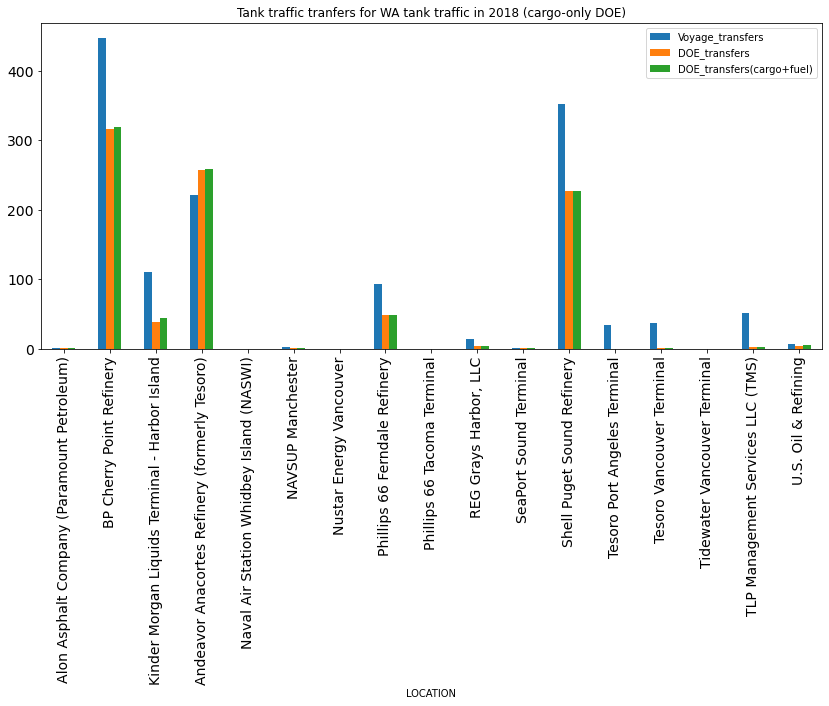

In [38]:
cam_WA.plot(y=['Voyage_transfers', 'DOE_transfers', 'DOE_transfers(cargo+fuel)'], kind = "bar",figsize=(14,6),fontsize=14)
plt.title('Tank traffic tranfers for WA tank traffic in 2018 (cargo-only DOE)')
plt.show()

## TAKE-AWAY: Voyage transfers over predict tank traffic cargo transfers.  Fueling stops for tankers does not explain this difference. One possible explanation is that our method includes ships that are either parked at doc or at close-by moorage awaiting a new job but not engaging in transfers. General pattern looks good for the large transfer sites.

### In this section, I compare the DOE transfers to the transfers in our 10,000 spill file
- Use `facility_names_mc` for monte carlo name list

In [39]:
file = '/Users/rmueller/Data/MIDOSS/monte_carlo/MonteCarloSpills_USdilbitexport_10000.csv'
monte_df = pd.read_csv(file)

monte_df['vessel_dest'] = monte_df['vessel_dest'].replace(
    ['Marathon Anacortes Refinery (formerly Tesoro)'],'Andeavor Anacortes Refinery (formerly Tesoro)'
)
monte_df['vessel_origin'] = monte_df['vessel_origin'].replace(
    ['Marathon Anacortes Refinery (formerly Tesoro)'],'Andeavor Anacortes Refinery (formerly Tesoro)'
)

In [40]:
monte_carlo_transfers = {}
for loc in facility_names:
    monte_carlo_transfers[loc]=len(monte_df[monte_df['vessel_origin']==loc]) + len(monte_df[monte_df['vessel_dest']==loc])
    
monte_carlo_df = pd.DataFrame(
    data=monte_carlo_transfers,
    index=[0]
)
monte_carlo_df.index  = ['monte_carlo_transfers']
monte_carlo_df=monte_carlo_df.transpose().sort_values(by=['monte_carlo_transfers'],ascending=False).copy()
monte_carlo_df.set_index = ['LOCATION']
# add DOE transfers without fuel
monte_carlo_df = monte_carlo_df.join(facility['transfers'], how='outer')
monte_carlo_df.columns = ['monte_carlo_transfers', 'DOE']
# add DOE transfers with fuel
monte_carlo_df = monte_carlo_df.join(facility_wfuel.transfers, how='outer')
# add Cam's voyages
monte_carlo_df = monte_carlo_df.join(cam_WA.Voyage_transfers, how='outer')
# label columns
monte_carlo_df.columns = ['monte_carlo_transfers', 'DOE', 'DOE_with_fuel','voyage_transfers']
monte_carlo_df['DOE'] = monte_carlo_df['DOE'].str.replace(",","").astype(float)
monte_carlo_df['DOE_with_fuel'] = monte_carlo_df['DOE_with_fuel'].str.replace(",","").astype(float)
monte_carlo_df

,monte_carlo_transfers,DOE,DOE_with_fuel,voyage_transfers
Alon Asphalt Company (Paramount Petroleum),24.0,451.0,459.0,2.0
Andeavor Anacortes Refinery (formerly Tesoro),59.0,425.0,425.0,221.0
BP Cherry Point Refinery,106.0,543.0,543.0,447.0
Kinder Morgan Liquids Terminal - Harbor Island,193.0,369.0,3021.0,110.0
NAVSUP Manchester,7.0,114.0,205.0,3.0
Naval Air Station Whidbey Island (NASWI),3.0,68.0,68.0,0.0
Nustar Energy Tacoma,0.0,3.0,3.0,NaN
Nustar Energy Vancouver,NaN,NaN,NaN,0.0
Phillips 66 Ferndale Refinery,129.0,638.0,639.0,94.0
Phillips 66 Tacoma Terminal,48.0,149.0,149.0,0.0


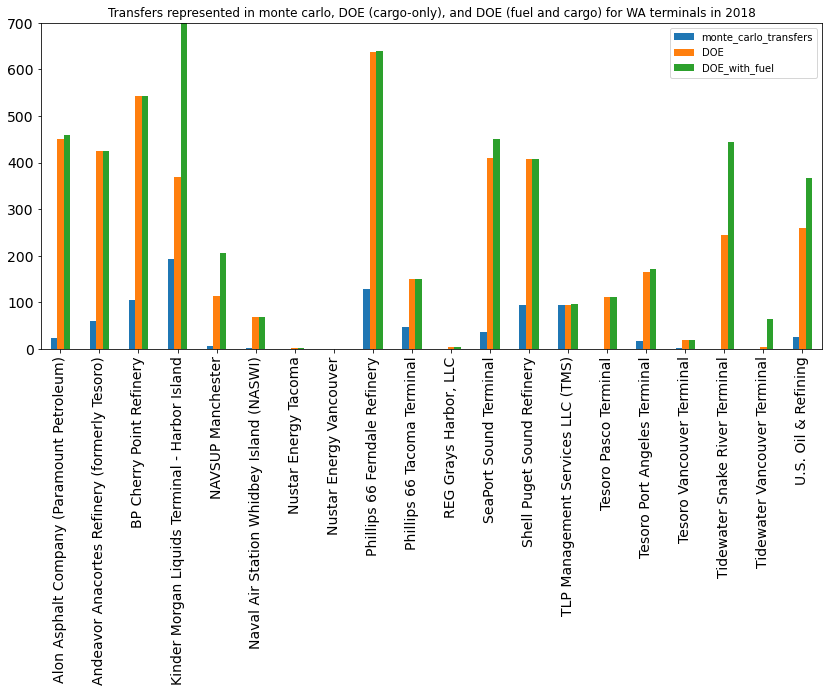

In [41]:
monte_carlo_df.plot(y=['monte_carlo_transfers', 'DOE', 'DOE_with_fuel'],kind = "bar",figsize=(14,6),fontsize=14,ylim=(0,700))
plt.title('Transfers represented in monte carlo, DOE (cargo-only), and DOE (fuel and cargo) for WA terminals in 2018')
plt.show()

### NOTE: I need to fix Maxum (Rainer Petroleum) as it's called "Maxum Petroleum - Harbor Island Terminal" in our monte-carlo file

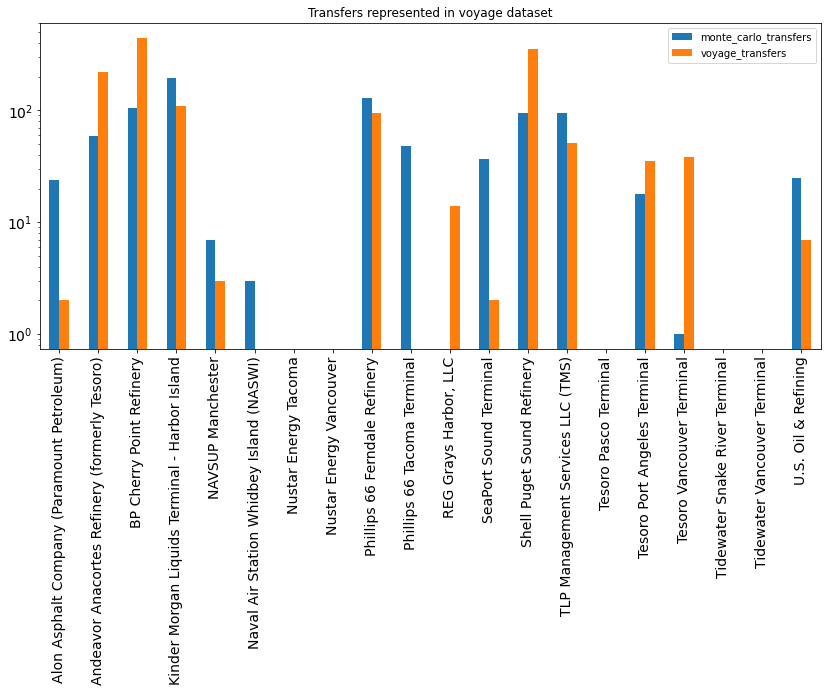

In [42]:
monte_carlo_df.plot(y=['monte_carlo_transfers','voyage_transfers'],kind = "bar",figsize=(14,6),fontsize=14)
plt.yscale('log')
plt.title('Transfers represented in voyage dataset')
plt.show()

## Repeat comparison between DOE transfers, voyage data and monte carlo selection using 100,000 monte carlo spills.

In [43]:
import os
from glob import glob
filenames = sorted(glob(os.path.join('/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/',"*.csv")))
filenames

['/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_1.csv',
 '/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_10.csv',
 '/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_2.csv',
 '/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_3.csv',
 '/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_4.csv',
 '/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_5.csv',
 '/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_6.csv',
 '/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_7.csv',
 '/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_8.csv',
 '/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_

In [44]:
df = pd.read_csv(filenames[0])
df.head(1)

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template
0,2018-03-30 18:00,7,-122.772003,48.346415,280,573,barge,366980170,Canada,US,710000.0,32000000.0,291100.0,fuel,Lagrangian_diesel.dat


### group data by vessel_origin and vessel_dest, removing all non-terminal transfers and changing names to match the DOE names listed in facility_names_mc

In [45]:
DOE_tanker.head()
DOE_tanker.index.names=['Facility']
DOE_tanker.head(1)

,DOE_transfers,DOE_transfers(cargo+fuel)
Facility,,
BP Cherry Point Refinery,316.0,319.0


### Create dataframe of monte-carlo transfers by talying transfers in each file
- Use `facility_names_mc` for monte carlo name list

In [46]:
# create a dataframe with zero transfers
mc100k = pd.DataFrame(facility_names)
mc100k = mc100k.set_index([0])
mc100k.index.names=['Facility']
mc100k.insert(0,'MC_transfers',np.zeros(mc100k.shape[0]),True)

# Loop through files and add transfers to "transfers" for each facility
counts = []
for fn in filenames:
    df = pd.read_csv(fn)
    
    # rename mc terminals to match DOE
    df['vessel_dest'] = df['vessel_dest'].replace(
        ['Marathon Anacortes Refinery (formerly Tesoro)'], 'Andeavor Anacortes Refinery (formerly Tesoro)'
    )
    df['vessel_origin'] = df['vessel_origin'].replace(
        ['Marathon Anacortes Refinery (formerly Tesoro)'],'Andeavor Anacortes Refinery (formerly Tesoro)'
    )

    # for imports
    by_dest = df.loc[
        (df.vessel_type == 'tanker') &
        (df.vessel_dest.isin(facility_names)),
    ].groupby('vessel_dest')
    count = by_dest.cargo_capacity.count()
    for index, value in enumerate(count):
        #print(count.index[index], mc100k.index.get_loc(count.index[index]))
        mc100k.MC_transfers[mc100k.index.get_loc(count.index[index])] += value
    
    # for exports
    by_origin = df.loc[
        (df.vessel_type == 'tanker') &
        (df.vessel_origin.isin(facility_names)),
    ].groupby('vessel_origin')
    count = by_origin.cargo_capacity.count()
    for index, value in enumerate(count):
        #print(count.index[index], mc100k.index.get_loc(count.index[index]))
        mc100k.MC_transfers[mc100k.index.get_loc(count.index[index])] += value

mc100k

,MC_transfers
Facility,
BP Cherry Point Refinery,270.0
Shell Puget Sound Refinery,168.0
Tidewater Snake River Terminal,0.0
Nustar Energy Tacoma,0.0
SeaPort Sound Terminal,0.0
Tesoro Vancouver Terminal,7.0
Phillips 66 Ferndale Refinery,57.0
Phillips 66 Tacoma Terminal,0.0
Andeavor Anacortes Refinery (formerly Tesoro),118.0


### Add monte-carlo transfers to DOE dataframe

In [47]:
DOE_tanker = DOE_tanker.join(
    mc100k.MC_transfers, 
    how='left'
)
DOE_tanker

,DOE_transfers,DOE_transfers(cargo+fuel),MC_transfers
Facility,,,
BP Cherry Point Refinery,316.0,319.0,270.0
Shell Puget Sound Refinery,227.0,227.0,168.0
Tidewater Snake River Terminal,1.0,1.0,0.0
Nustar Energy Tacoma,0.0,0.0,0.0
SeaPort Sound Terminal,1.0,1.0,0.0
Tesoro Vancouver Terminal,2.0,2.0,7.0
Phillips 66 Ferndale Refinery,49.0,49.0,57.0
Phillips 66 Tacoma Terminal,0.0,0.0,0.0
Andeavor Anacortes Refinery (formerly Tesoro),258.0,259.0,118.0


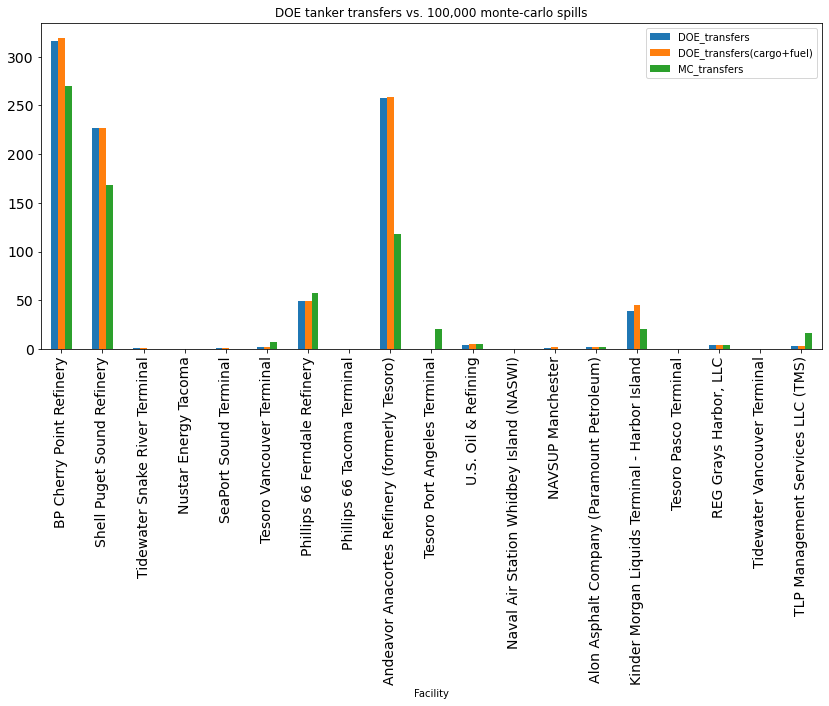

In [48]:
DOE_tanker.plot(
    y=['DOE_transfers','DOE_transfers(cargo+fuel)', 'MC_transfers'],
    kind = "bar",
    figsize=(14,6),
    fontsize=14
)
#plt.yscale('log')
plt.title('DOE tanker transfers vs. 100,000 monte-carlo spills')
plt.show()

### Why do we miss Anacortes? 

### Concatenate all data

In [49]:
df={}
for index,fn in enumerate(filenames):
    print(index,fn)
    df[index] = pd.read_csv(fn)
    if index == 0:
        df_combined = df[index].copy()
    else:
        df_combined = pd.concat([df_combined, df[index]])

0 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_1.csv
1 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_10.csv
2 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_2.csv
3 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_3.csv
4 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_4.csv
5 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_5.csv
6 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_6.csv
7 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_7.csv
8 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_8.csv
9 /Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/SalishSea_oil_spills_10000_9.csv

In [50]:
df[0].shape

(10000, 15)

In [51]:
df_combined.shape

(100000, 15)

In [52]:
df_combined.head(1)

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template
0,2018-03-30 18:00,7,-122.772003,48.346415,280,573,barge,366980170,Canada,US,710000.0,32000000.0,291100.0,fuel,Lagrangian_diesel.dat


### Look for Maxum transfers in combined 100,000 spills file

In [53]:
maxum = df_combined[['vessel_origin','vessel_dest']]#.groupby('vessel_origin').count()
print(maxum.groupby('vessel_dest').count())
print(maxum.groupby('vessel_origin').count())

                                                vessel_origin
vessel_dest                                                  
Alon Asphalt Company (Paramount Petroleum)                129
BP Cherry Point Refinery                                  441
Barge Mooring Near Stanovan                               270
Canada                                                  11928
Chevron Cobble Hill                                        50
Chevron Stanovan                                           75
ESSO IOCO Vancouver                                        31
ESSO Nanaimo Departure Bay                                 87
Kinder Morgan Liquids Terminal - Harbor Island            747
Marathon Anacortes Refinery (formerly Tesoro)             266
NAVSUP Manchester                                          43
Naval Air Station Whidbey Island (NASWI)                   23
Pacific                                                  1883
Phillips 66 Ferndale Refinery                             603
Phillips

### Take-away: No Maxum in either origin or destination of 100,000 spills file

(0.0, 150.0)

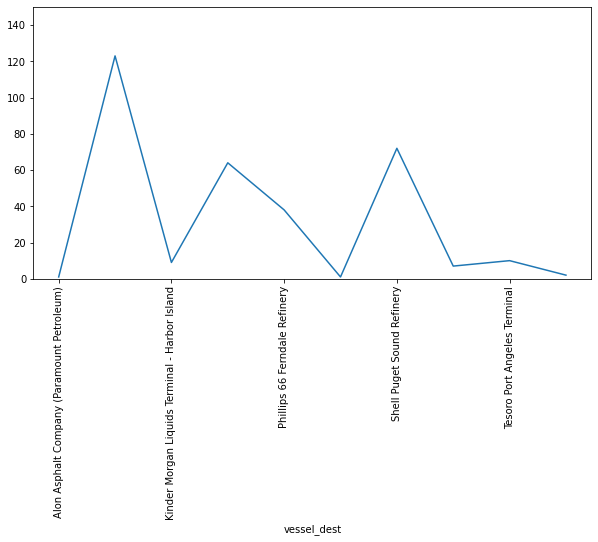

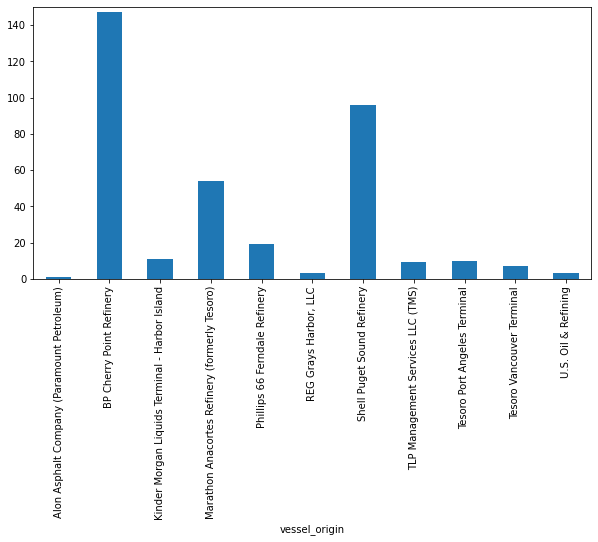

In [54]:
# tally tanker imports by location for all files (100,000 spills)
location_count_in = df_combined.loc[
    (df_combined.vessel_type == 'tanker') &
    (df_combined.vessel_dest.isin(facility_names_mc)),
    ['spill_volume','vessel_dest']
].groupby('vessel_dest').count()

fig, axs = plt.subplots(1, 1,figsize=(10,5))
location_count_in.spill_volume.plot(ax=axs)
axs.tick_params('x', labelrotation=90)
axs.set_ylim(0,150)
#fig.tight_layout()

#ax1.set_xticklabels(location_count_in.spill_volume.keys(), Fontsize= 12)
#ax1.tick_params('x',labelrotation=45)
#ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
#plt.setp(ax1.get_xticklabels(), Rotation=45)
#ax1.set_xticks(location_count_in.spill_volume.keys())
#ax1.set_xticklabels(location_count_in.spill_volume.keys())
# tally tanker exports by location for all files (100,000 spills)
location_count_out = df_combined.loc[
    (df_combined.vessel_type == 'tanker') &
    (df_combined.vessel_origin.isin(facility_names_mc)),
    ['spill_volume','vessel_origin']
].groupby('vessel_origin').count()

fig, axs = plt.subplots(1, 1,figsize=(10,5))
location_count_out.spill_volume.plot(ax=axs,kind = "bar")
#axs.tick_params('x', labelrotation=45)
axs.set_ylim(0,150)

#fig.tight_layout()
# ax2=location_count_out.spill_volume.plot()
# ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)



In [55]:
location_count_out.spill_volume.keys()

Index(['Alon Asphalt Company (Paramount Petroleum)',
       'BP Cherry Point Refinery',
       'Kinder Morgan Liquids Terminal - Harbor Island',
       'Marathon Anacortes Refinery (formerly Tesoro)',
       'Phillips 66 Ferndale Refinery', 'REG Grays Harbor, LLC',
       'Shell Puget Sound Refinery', 'TLP Management Services LLC (TMS)',
       'Tesoro Port Angeles Terminal', 'Tesoro Vancouver Terminal',
       'U.S. Oil & Refining'],
      dtype='object', name='vessel_origin')

In [56]:
location_count_in.spill_volume.keys()

Index(['Alon Asphalt Company (Paramount Petroleum)',
       'BP Cherry Point Refinery',
       'Kinder Morgan Liquids Terminal - Harbor Island',
       'Marathon Anacortes Refinery (formerly Tesoro)',
       'Phillips 66 Ferndale Refinery', 'REG Grays Harbor, LLC',
       'Shell Puget Sound Refinery', 'TLP Management Services LLC (TMS)',
       'Tesoro Port Angeles Terminal', 'U.S. Oil & Refining'],
      dtype='object', name='vessel_dest')

In [57]:
location_count_out.keys()

Index(['spill_volume'], dtype='object')

### plot up files by vessel type

Text(0.5, 1.0, 'Volume of spills by vessel type for every 10,000 spills .csv file')

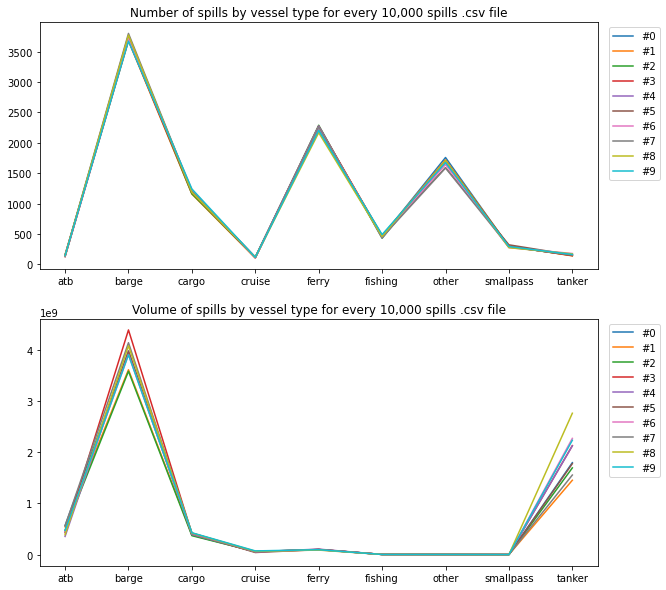

<Figure size 720x720 with 0 Axes>

In [58]:
vessel_types = vessel_types = [
    'tanker', 
    'atb', 
    'barge', 
    'cargo', 
    'cruise',
    'ferry', 
    'fishing', 
    'smallpass', 
    'other'
]
# create dictionary to tally spills by vessel
spill_count = {}
spill_volume = {}
# loop through each 10,000 spill file and plot:
fig1 = plt.figure(figsize=(10, 10))
fig2 = plt.figure(figsize=(10, 10))
#1) spill count by vessel type
ax1 = fig1.add_subplot(211)
#2) spill volume by vessel type
ax2 = fig1.add_subplot(212)
for file_index,file in enumerate(filenames):
    #print(file_index,file)
    df[file_index] = pd.read_csv(file)
    spill_count[file_index] = {}
    spill_volume[file_index]={}
    # calculate and catalogue spill count
    spill_count[file_index] = df[file_index][
            ['spill_volume','vessel_type']
        ].groupby('vessel_type').count()
    spill_count[file_index] = spill_count[file_index].rename(
        columns = {'spill_volume':'spill_count'}
    )
    # calculate and catalogue spill volume
    spill_volume[file_index] = df[file_index][
            ['spill_volume','vessel_type']
        ].groupby('vessel_type').sum()
    #ax = spill_count[file_index].spill_count[:].plot(label={'File #'file_index})
    ax1.plot(
        spill_count[file_index].spill_count[:],
        '-',
        label=f'#{file_index}',
    )
    ax2.plot(
        spill_volume[file_index].spill_volume[:],
        '-',
        label=f'#{file_index}'
    )
ax1.legend(bbox_to_anchor=(1.12, 1.0),loc=1)
ax2.legend(bbox_to_anchor=(1.12, 1.0),loc=1)
ax1.set_title('Number of spills by vessel type for every 10,000 spills .csv file')
ax2.set_title('Volume of spills by vessel type for every 10,000 spills .csv file')


### (Triple?) check that the DOE shows transfers for Maxum and Andeaover Anacortes.  Andeaover was Marathon, so I do check by Anacortes tag to cover all bases.

Explicitly set tick locations: plt.xticks(np.arange(min(x), max(x)+1, 1.0)) or 
    use tick locators: https://matplotlib.org/stable/gallery/ticks_and_spines/tick-locators.html